In [1]:
# prompt: mount the content of the folder called AIR_Project in google drive here

from google.colab import drive
drive.mount('/content/drive')

!ln -s "/content/drive/My Drive/AIR_Project" "/content/AIR_Project"


Mounted at /content/drive


In [2]:
import AIR_Project.dataset_preparation as dataset_preparation

Train dataset loaded successfully with 82022 records.
Val dataset loaded successfully with 5592 records.
Test dataset loaded successfully with 5593 records.


In [3]:
# Load the datasets
df_train_data = dataset_preparation.get_train_dataset()
df_val_data = dataset_preparation.get_val_dataset()
df_test_data = dataset_preparation.get_test_dataset()

In [4]:
print(df_train_data)
print('-'*50)
print(df_val_data)
print('-'*50)
print(df_test_data)

                                                 article  \
1      به گزارش شانا، علی کاردر امروز (۲۷ دی ماه) در ...   
2      به گزارش شانا به نقل از شرکت ملی صنایع پتروشیم...   
3      به گزارش شانا به نقل از شرکت پالایش گاز شهید ه...   
4      به گزارش خبرنگار ایمنا، سعید نظری در صفحه اینس...   
5      به گزارش شانا، سیدباقر مرتضوی، مشاور وزیر نفت ...   
...                                                  ...   
82018  به گزارش ایمنا، تیم‌های ملی هاکی زنان و مردان ...   
82019  به گزارش بازار، مصطفی قلی خسروی افزود: در کشور...   
82020  به گزارش ایمنا، به نقل از پایگاه اطلاع‌رسانی ک...   
82021  به گزارش خبرگزاری خبرآنلاین و به نقل از ایران ...   
82022  به گزارش شانا به نقل از دبیرخانه سازمان کشورها...   

                                                 summary  
1      مدیرعامل شرکت ملی نفت، عملکرد مدیریت امور بین‎...  
2      سرپرست مدیریت برنامه‌ریزی و توسعه شرکت ملی صنا...  
3      پالایشگاه گاز خانگیران با هدف معرفی گوگرد بنتو...  
4      سخنگوی شورای شهر شیراز گفت: روند عمر

In [17]:
!pip install --quiet  tqdm     #for progress bars
!pip install --quiet transformers # for t5 model
!pip install --quiet tokenizers  #tokenizers from HuggingFace
!pip install --quiet sentencepiece #subword tokenizer used by T5
!pip install --quiet pytorch-lightning # pytorch wrapper
!pip install --quiet torchtext # text utilities
!pip install --quiet evaluate==0.4.3
!pip install --quiet bert_score
!pip install --quiet rouge_score

  Preparing metadata (setup.py) ... done


In [6]:
import evaluate
from transformers import pipeline
from bert_score import plot_example
import matplotlib.pyplot as plt
import statistics
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from pprint import pprint
import copy
from transformers import (
    AdamW,
    MT5ForConditionalGeneration,
    MT5Tokenizer,
    get_linear_schedule_with_warmup
)

In [7]:
device  = 'cuda' if torch.cuda.is_available() else "cpu"

In [8]:
mt5_tokenizer = MT5Tokenizer.from_pretrained('google/mt5-small',model_max_length=512)
mt5_model = MT5ForConditionalGeneration.from_pretrained('google/mt5-small')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [9]:
class TextSummarizationDataset(Dataset):
    def __init__(self, tokenizer, split='train', max_len_inp=512,max_len_out=96):
        self.split = split

        self.article_column = "article"
        self.summary_column = "summary"

        if self.split == 'train':
          self.data = df_train_data
        elif self.split == 'val':
          self.data = df_val_data
        elif self.split == 'test':
          self.data = df_test_data

        self.max_len_input = max_len_inp
        self.max_len_output = max_len_out
        self.tokenizer = tokenizer
        self.inputs = []
        self.targets = []
        self._build()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()
        target_ids = self.targets[index]["input_ids"].squeeze()

        src_mask = self.inputs[index]["attention_mask"].squeeze()  #squeeze to get rid of the batch dimension
        target_mask = self.targets[index]["attention_mask"].squeeze()  # convert [batch,dim] to [dim]

        labels = copy.deepcopy(target_ids)
        labels [labels==0] = -100

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask,"labels":labels}

    def _build(self):
        for rownum,val in tqdm(self.data.iterrows()): # Iterating over the dataframe
            article,summary = val[self.article_column],val[self.summary_column]

            input_ = article # Input format for text summarization tasks
            target = summary # Output format we require

            # tokenize inputs
            tokenized_inputs = self.tokenizer.batch_encode_plus(
                [input_], max_length=self.max_len_input,padding='max_length',
                truncation = True,return_tensors="pt"
            )
            # tokenize targets
            tokenized_targets = self.tokenizer.batch_encode_plus(
                [target], max_length=self.max_len_output,padding='max_length',
                truncation = True,
                return_tensors="pt"
            )

            self.inputs.append(tokenized_inputs)
            self.targets.append(tokenized_targets)

In [10]:
train_dataset = TextSummarizationDataset(mt5_tokenizer, 'train')
val_dataset = TextSummarizationDataset(mt5_tokenizer, 'val')
test_dataset = TextSummarizationDataset(mt5_tokenizer, 'test')

82022it [05:55, 230.89it/s]
5592it [00:24, 231.77it/s]
5593it [00:24, 232.45it/s]


In [11]:
# Data Sample

train_sample = train_dataset[50]
decoded_train_input = mt5_tokenizer.decode(train_sample['source_ids'])
decoded_train_output = mt5_tokenizer.decode(train_sample['target_ids'])

print(f'sample_train_input : {decoded_train_input}')
print(f'sample_train_output : {decoded_train_output}')

val_sample = train_dataset[50]
decoded_val_input = mt5_tokenizer.decode(val_sample['source_ids'])
decoded_val_output = mt5_tokenizer.decode(val_sample['target_ids'])

print(f'sample_val_input : {decoded_val_input}')
print(f'sample_val_output : {decoded_val_output}')

test_sample = test_dataset[50]
decoded_test_input = mt5_tokenizer.decode(test_sample['source_ids'])
decoded_test_output = mt5_tokenizer.decode(test_sample['target_ids'])

print(f'sample_test_input : {decoded_test_input}')
print(f'sample_test_output : {decoded_test_output}')

sample_train_input : به گزارش ایمنا، محمدباقر نوبخت با اشاره به قیمت دلار در لایحه بودجه ۹۹ اظهار کرد: قیمت دلار برای کالاهای اساسی در لایحه بودجه ۹۹ همچنان چهار هزار و ۲۰۰ تومان پیش بینی شده است. [n] وی تصمیم دولت را برای استفاده از ارز چهار هزار و ۲۰۰ تومانی قطعی عنوان و درباره دلایل استفاده از ارز ارزان قیمت برای کالاهای اساسی تصریح کرد: دولت به دنبال مهار تورم است و اگر به جای دلار چهار هزار و ۲۰۰ تومانی، از ارز نیمایی استفاده شود، یعنی پذیرفته ایم از ابتدای فرودین ماه ۹۹، مرغ و شکر با دلار حدود ۱۱ هزار تومانی تامین شود که در این شرایط همه چیز گران خواهد شد. [n] رئیس سازمان برنامه و بودجه در پاسخ به این پرسش که آیا دولت در لایحه بودجه ۹۹ از کالابرگ الکترونیک کهکی از روش های مجلس برای تامین کالاهای اساسی در بودجه ۹۸ بود، استفاده نمی کند، ادامه داد: در حال حاضر تامین کالاهای اساسی با دلار چهار هزار و ۲۰۰ تومانی در کشور به رویه ای عادی تبدیل شده است. [n] وی اضافه کرد: در یک دوره، با وجود استفاده از ارز چهار هزار و ۲۰۰ تومانی، قیمت ها افزایش پیدا می کرد، اما در حال حاضر این روش مسلط شد

In [ ]:
import pytorch_lightning as pl
from torch.optim import AdamW
import argparse
from transformers import (
    get_linear_schedule_with_warmup
  )

class MT5Tuner(pl.LightningModule):

    def __init__(self,mt5model, mt5tokenizer,batchsize=4):
        super().__init__()
        self.model = mt5model
        self.tokenizer = mt5tokenizer
        self.batch_size = batchsize

    def forward( self, input_ids, attention_mask=None,
                decoder_attention_mask=None,
                lm_labels=None):

         outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
        )

         return outputs

    def training_step(self, batch, batch_idx):
        outputs = self.forward(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            decoder_attention_mask=batch['target_mask'],
            lm_labels=batch['labels']
        )

        loss = outputs[0]
        self.log('train_loss',loss)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self.forward(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            decoder_attention_mask=batch['target_mask'],
            lm_labels=batch['labels']
        )

        loss = outputs[0]
        self.log("val_loss",loss)
        return loss

    def train_dataloader(self):
        return DataLoader(train_dataset, batch_size=self.batch_size,
                          num_workers=2)

    def val_dataloader(self):
        return DataLoader(val_dataset, batch_size=self.batch_size,
                          num_workers=2)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=3e-4, eps=1e-8)
        return optimizer

In [12]:
trained_model_path = 'AIR_Project/mt5_trained_model'
trained_tokenizer = 'AIR_Project/mt5_tokenizer'

!mkdir -p "AIR_Project/mt5_trained_model"
!mkdir -p "AIR_Project/mt5_tokenizer"

In [ ]:
mt5_model = MT5ForConditionalGeneration.from_pretrained(trained_model_path)
mt5_tokenizer = MT5Tokenizer.from_pretrained(trained_tokenizer)

In [ ]:
model = MT5Tuner(mt5_model,mt5_tokenizer)

epochs=1

for epoch in range(epochs):
    trainer = pl.Trainer(max_epochs=1,accelerator=device)
    trainer.fit(model)

    mt5_model.save_pretrained(trained_model_path)
    mt5_tokenizer.save_pretrained(trained_tokenizer)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                        | Params | Mode
-------------------------------------------------------------
0 | model | MT5ForConditionalGeneration | 300 M  | eval
-------------------------------------------------------------
300 M     Trainable params
0         Non-trainable params
300 M     Total params
1,200.707 Total estimated model params size (MB)
0         Modules in train mode
381       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [13]:
model = MT5ForConditionalGeneration.from_pretrained(trained_model_path).to(device)
tokenizer = MT5Tokenizer.from_pretrained(trained_tokenizer)

In [14]:
for i in range(10):
    item = val_dataset[i]

    article = tokenizer.decode(item['source_ids'], skip_special_tokens=True,clean_up_tokenization_spaces=True)
    summary = tokenizer.decode(item['target_ids'], skip_special_tokens=True,clean_up_tokenization_spaces=True)

    encoding = tokenizer.encode_plus(article,max_length =512,padding='max_length',
                                 truncation = True,
                                 return_tensors="pt").to(device)
    input_ids,attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

    model.eval()
    beam_outputs = model.generate(
      input_ids=input_ids,
      attention_mask=attention_mask,
      max_length=72, # How long the generated summary should be
      early_stopping=True,
      num_beams=5,
      num_return_sequences=1
    )

    for beam_output in beam_outputs:
      predicted = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
      print(f"article : {article}")
      print(f'true summary : {summary}')
      print(f"predicted summary : {predicted}")
      print('-'*50)

article : مدیر بازرگانی شرکت ملی پخش فرآورده های نفتی، در گفتگو با شانا با بیان این که بر اساس مجوز یکشنبه (۱۸ اسفند ماه) شورای اقتصاد، کارمزد بنزین در جایگاههای عرضه فرآورده های نفتی کلانشهر تهران افزایش یافته است، افزود: این کارمزد با احتساب ۱۰۰ ریال کارمزد ویژه برای آن، ۳۵۰ ریال به ازای فروش هر لیتر بنزین تعیین شده است. [n] محمدرضا مظلومی تصریح کرد: در دیگر کلانشهرهای کشور نیز کارمزد این فرآورده نفتی (بنزین) با احتساب ۴۰ ریال کارمزد ویژه، ۲۹۰ ریال به ازای فروش هر لیتر بنزین در نظر گرفته شده است. [n] به گفته وی، کارمزد در دیگر جایگاههای عرضه فرآورده نیز به ازای هر لیتر فروش بنزین ۲۵۰ ریال است. [n] تا پیش از مصوبه شورای اقتصاد کارمزد فروش بنزین به ازای هر لیتر آن ۲۰۰ ریال محاسبه می شد. [n] مدیر بازرگانی شرکت ملی پخش فرآورده های نفتی با بیان این که برای جلوگیری از هرگونه مشکل برای جایگاه داران، در ماههای اخیر ۲۰ درصد از کارمزد جایگاههای عرضه سوخت به صورت علی الحساب به آنها پرداخت شده است، تصریح کرد: کارمزد قطعی (بر اساس نرخهای جدید) از ابتدای سال ۱۳۹۲ محاسبه و پرداخت می شود. [n] مظلومی

In [15]:
articles = []
references = []
hypotheses = []

num = len(test_dataset)

for i in tqdm(range(num)):
    item = test_dataset[i]

    article = tokenizer.decode(item['source_ids'], skip_special_tokens=True,clean_up_tokenization_spaces=True)
    summary = tokenizer.decode(item['target_ids'], skip_special_tokens=True,clean_up_tokenization_spaces=True)

    articles.append(article)
    references.append(summary)

    encoding = tokenizer.encode_plus(article,max_length =512,padding='max_length',
                                 truncation = True,
                                 return_tensors="pt").to(device)
    input_ids,attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

    model.eval()
    beam_outputs = model.generate(
      input_ids=input_ids,
      attention_mask=attention_mask,
      max_length=72, # How long the generated summary should be
      early_stopping=True,
      num_beams=5,
      num_return_sequences=1
    )

    for beam_output in beam_outputs:
      predicted = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
      hypotheses.append(predicted)

100%|██████████| 5593/5593 [1:59:36<00:00,  1.28s/it]


In [18]:
rouge = evaluate.load('rouge')

In [19]:
results = rouge.compute(predictions=hypotheses, references=references, tokenizer=lambda x: x.split())

rouge1_score = results.get('rouge1', None)
print(f'rouge1_score : {rouge1_score}')

rouge2_score = results.get('rouge2', None)
print(f'rouge2_score : {rouge2_score}')

rougeL_score = results.get('rougeL', None)
print(f'rougeL_score : {rougeL_score}')

rougeLsum_score = results.get('rougeLsum', None)
print(f'rougeLsum_score : {rougeLsum_score}')

rouge1_score : 0.4113370639658706
rouge2_score : 0.24390918922819255
rougeL_score : 0.3594116552014613
rougeLsum_score : 0.35976731067173684


In [20]:
bertscore = evaluate.load("bertscore")

In [21]:
results = bertscore.compute(predictions=hypotheses, references=references, lang="fa")

F1 = results.get('f1', None)
P = results.get('precision', None)
R = results.get('recall', None)

print(f"Bert Score F1 score: {statistics.mean(F1):.3f}")
print(f"Bert Score Precision score: {statistics.mean(P):.3f}")
print(f"Bert Score Recall score: {statistics.mean(R):.3f}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Bert Score F1 score: 0.782
Bert Score Precision score: 0.786
Bert Score Recall score: 0.780


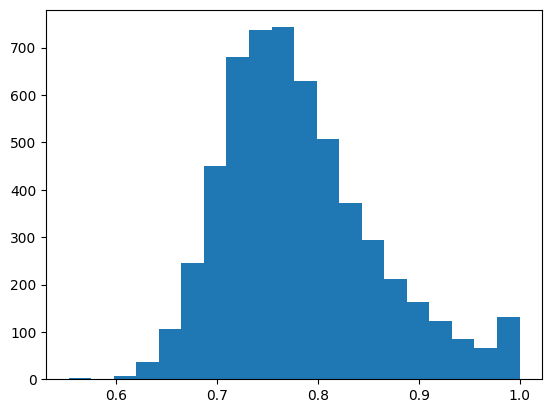

In [22]:
plt.hist(F1, bins=20)
plt.show()

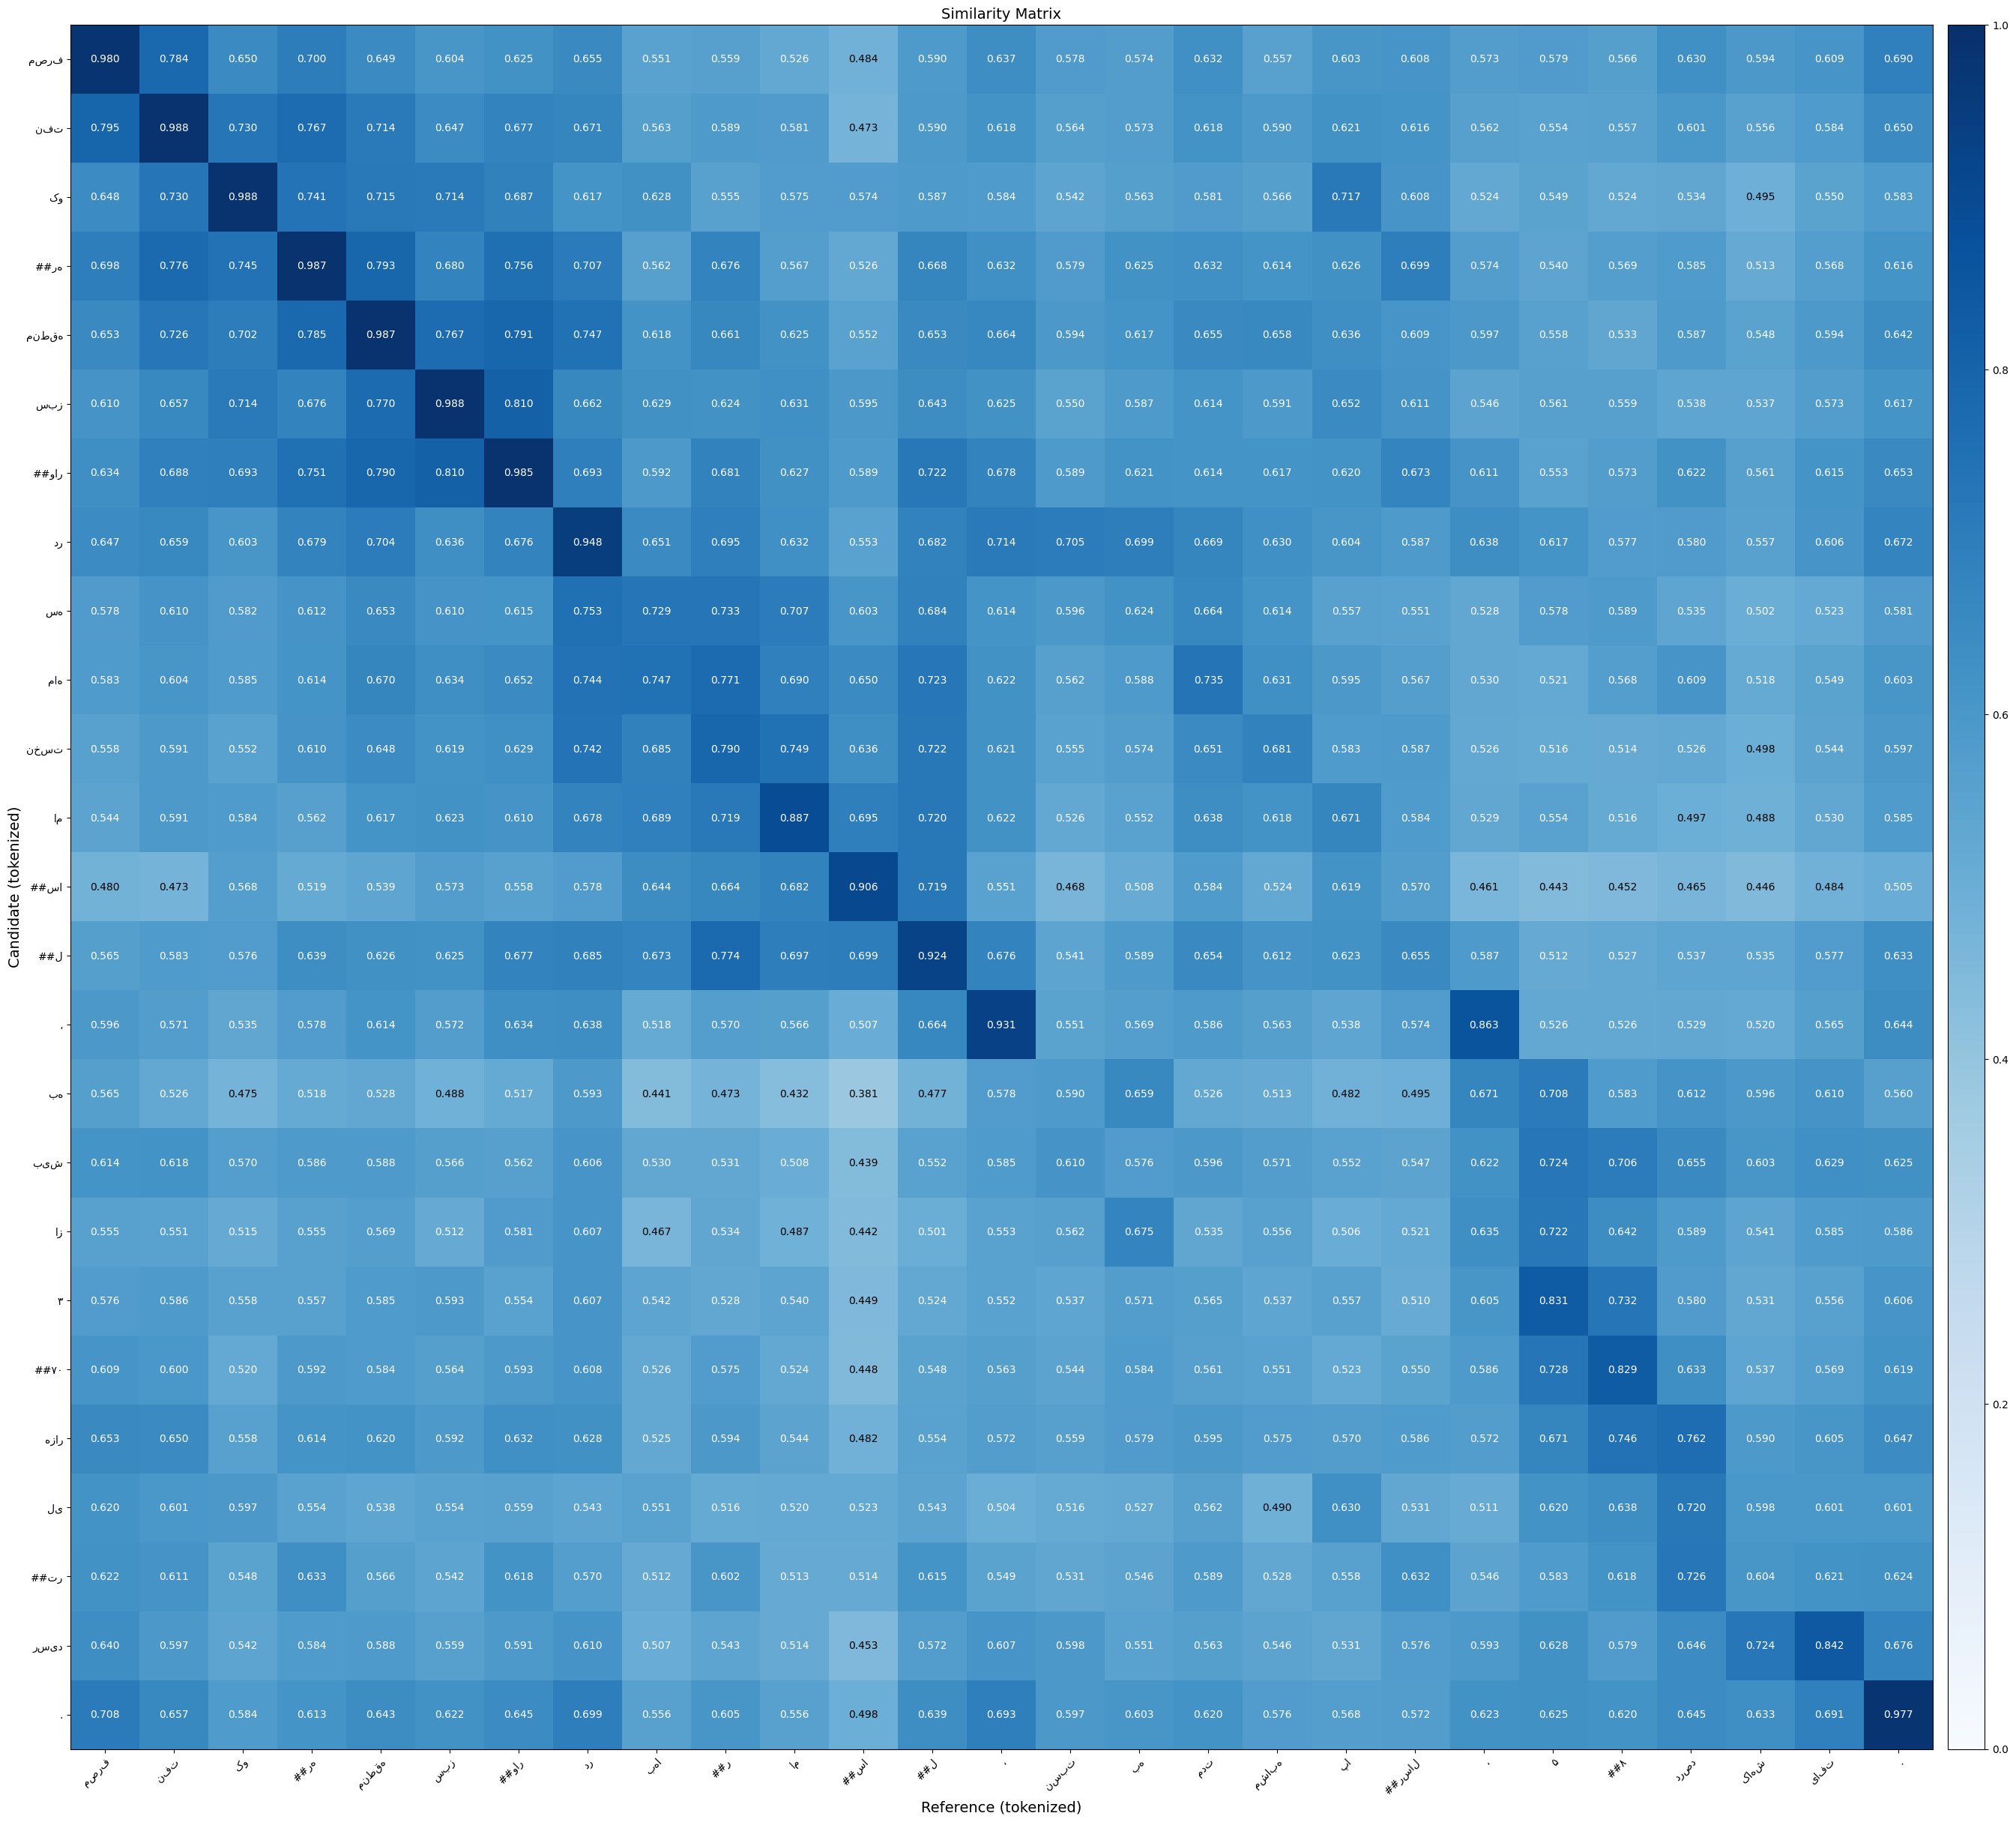

In [23]:
hypo = hypotheses[0]
ref = references[0]
plot_example(hypo, ref, lang="fa")

In [24]:
# Load the NER pipeline
ner_pipeline = pipeline("ner", model='HooshvareLab/bert-base-parsbert-ner-uncased')

config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/651M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-ner-uncased were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [25]:
name_entity_references = []

for reference in references:
    entities = ner_pipeline(reference)
    words = []
    for entity in entities:
        word = entity['word']
        words.append(word)
    words_str = ' '.join(words)
    name_entity_references.append(words_str)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [26]:
name_entity_hypotheses = []

for hypothese in hypotheses:
    entities = ner_pipeline(hypothese)
    words = []
    for entity in entities:
        word = entity['word']
        words.append(word)
    words_str = ' '.join(words)
    name_entity_hypotheses.append(words_str)

In [27]:
for i in range(10):
  print(f'Reference name entities : {name_entity_references[i]}')
  print(f'hypothese name entities : {name_entity_hypotheses[i]}')
  print('-'*50)

Reference name entities : منطقه سبزوار بهار امسال پارسال ۵۸ درصد
hypothese name entities : منطقه سبزوار سه ماه نخست امسال
--------------------------------------------------
Reference name entities : 
hypothese name entities : ایران
--------------------------------------------------
Reference name entities : سازمان کشورهای صادرکننده نفت اوپک
hypothese name entities : سازمان کشورهای صادرکننده نفت اوپک
--------------------------------------------------
Reference name entities : سازمان اتش نشانی اصفهان خیابان بهارستان غربی
hypothese name entities : سازمان اتش نشانی و خدمات ایمنی شهرداری اصفهان
--------------------------------------------------
Reference name entities : بی بی س ترامپ بایدن پنسیلوانیا جورجیا
hypothese name entities : ایسنا جو بایدن امریکا
--------------------------------------------------
Reference name entities : امورخارجه ایران کوبا
hypothese name entities : امورخارجه ایران کوبا
--------------------------------------------------
Reference name entities : شهرضا شورای اسلامی

In [28]:
results = bertscore.compute(predictions=name_entity_hypotheses, references=name_entity_references, lang="fa")

name_entity_F1 = results.get('f1', None)
name_entity_P = results.get('precision', None)
name_entity_R = results.get('recall', None)

print(f"name_entity_Bert Score F1 score: {statistics.mean(name_entity_F1):.3f}")
print(f"name_entity_Bert Score Precision score: {statistics.mean(name_entity_P):.3f}")
print(f"name_entity_Bert Score Recall score: {statistics.mean(name_entity_R):.3f}")

name_entity_Bert Score F1 score: 0.758
name_entity_Bert Score Precision score: 0.759
name_entity_Bert Score Recall score: 0.759
